# Improving on the baseline

Last time, we learned how to take advantage of the [hard work] of the good people at Oxford (now at Google) in order to improve our classifier (err, hotdog detector!). That way, we got a CNN architecture designed by some of the best in the world (I have to say, designed in 2014... we could probably use a better one now). We also saved a ton of money in GPU leasing fees, and got a nice bump to our performance.

However, with the last increase in model complexity, we went over the line. We got some overfitting, so now we have to implement once again a regularization technique. We are going to implement one that actually isn't implemented in VGG16, so if we could go back in time just 4 years, we could have the best image classifier in the world. Its name is [dropout].


[dropout]: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
[hard work]: https://arxiv.org/abs/1409.1556

# Dropout

Dropout is a very counterintuitive technique when you first hear about it, but it really makes a lot of sense after a while. It consists of ignoring the output of some of the units in a layer 

In [1]:
import keras
from keras import backend as K
from keras.applications import VGG16

vgg = VGG16(weights='imagenet', 
            include_top=False, 
            input_shape=(120,120,3))



Using TensorFlow backend.


In [2]:
from keras.layers import Dense, Dropout, Flatten

vgg.trainable = False

detector = keras.Sequential()
detector.add(vgg)
detector.add(Flatten())
detector.add(Dropout(.5))
detector.add(Dense(128, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(128, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(64, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(1, activation='sigmoid'))


detector.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [4]:
from keras.optimizers import Adam

detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = detector.fit_generator(train_generator,
                                 steps_per_epoch=20,
                                 epochs=40,
                                 validation_data=validation_generator,
                                 validation_steps=10)

detector.save('06-frozen-10e-3.h5')

Epoch 1/40
20/20 [==============================] - 32s 2s/step - loss: 0.5683 - acc: 0.8085 - val_loss: 0.4243 - val_acc: 0.8725
Epoch 2/40
20/20 [==============================] - 13s 641ms/step - loss: 0.4052 - acc: 0.8635 - val_loss: 0.3332 - val_acc: 0.8694
Epoch 3/40
20/20 [==============================] - 15s 733ms/step - loss: 0.3780 - acc: 0.8683 - val_loss: 0.2861 - val_acc: 0.8735
Epoch 4/40
20/20 [==============================] - 14s 699ms/step - loss: 0.3436 - acc: 0.8681 - val_loss: 0.2586 - val_acc: 0.8735
Epoch 5/40
20/20 [==============================] - 14s 676ms/step - loss: 0.3208 - acc: 0.8690 - val_loss: 0.2548 - val_acc: 0.8755
Epoch 6/40
20/20 [==============================] - 14s 706ms/step - loss: 0.3080 - acc: 0.8735 - val_loss: 0.2375 - val_acc: 0.8684
Epoch 7/40
20/20 [==============================] - 14s 686ms/step - loss: 0.2835 - acc: 0.8816 - val_loss: 0.2349 - val_acc: 0.8704
Epoch 8/40
20/20 [==============================] - 16s 795ms/step - los

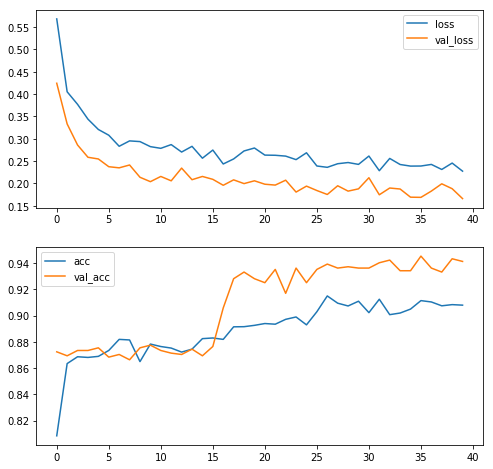

In [5]:
from mateosio import plot_training_histories
%matplotlib inline

plot_training_histories(history);

OK! so we have prevented overfitting! Let's push a bit more.

In [6]:
from keras.optimizers import Adam

detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt2 = detector.fit_generator(train_generator,
                                     steps_per_epoch=20,
                                     epochs=30,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-frozen-10e-4.h5')

Epoch 1/40
20/20 [==============================] - 17s 868ms/step - loss: 0.2523 - acc: 0.9096 - val_loss: 0.1700 - val_acc: 0.9403
Epoch 2/40
20/20 [==============================] - 14s 701ms/step - loss: 0.2305 - acc: 0.9100 - val_loss: 0.1652 - val_acc: 0.9443
Epoch 3/40
20/20 [==============================] - 14s 693ms/step - loss: 0.2317 - acc: 0.9130 - val_loss: 0.1666 - val_acc: 0.9443
Epoch 4/40
20/20 [==============================] - 14s 709ms/step - loss: 0.2451 - acc: 0.9065 - val_loss: 0.1735 - val_acc: 0.9393
Epoch 5/40
20/20 [==============================] - 14s 677ms/step - loss: 0.2144 - acc: 0.9267 - val_loss: 0.1715 - val_acc: 0.9413
Epoch 6/40
20/20 [==============================] - 13s 644ms/step - loss: 0.2165 - acc: 0.9154 - val_loss: 0.1748 - val_acc: 0.9443
Epoch 7/40
20/20 [==============================] - 13s 669ms/step - loss: 0.2173 - acc: 0.9125 - val_loss: 0.1700 - val_acc: 0.9464
Epoch 8/40
20/20 [==============================] - 15s 768ms/step - 

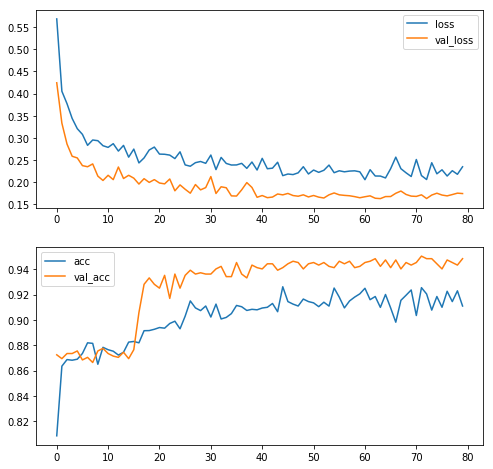

In [7]:
plot_training_histories(history, history_pt2);

Wow, now we have some recalcitrant underfitting! Time to complexify the model, I guess! We'll unfreeze the convolutional base, like we did in the previous notebook. Let's hope we have hit the sweet spot of the bias-variance trade-off.

### Fine Tuning

In [8]:
# The VGG16 inside my model:

detector.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [9]:
for layer in detector.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
        
# Set the vgg as a whole to trainable:        
detector.layers[0].trainable = True   

In [10]:
[layer.trainable for layer in detector.layers[0].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [11]:
detector.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [12]:
detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt3 = detector.fit_generator(train_generator,
                                     steps_per_epoch=20,
                                     epochs=20,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-unfrozen-10e-4.h5')

Epoch 1/20
20/20 [==============================] - 18s 883ms/step - loss: 0.2485 - acc: 0.9105 - val_loss: 0.1997 - val_acc: 0.9362
Epoch 2/20
20/20 [==============================] - 13s 662ms/step - loss: 0.2269 - acc: 0.9247 - val_loss: 0.2042 - val_acc: 0.9302
Epoch 3/20
20/20 [==============================] - 14s 705ms/step - loss: 0.2156 - acc: 0.9165 - val_loss: 0.1586 - val_acc: 0.9464
Epoch 4/20
20/20 [==============================] - 13s 675ms/step - loss: 0.2241 - acc: 0.9079 - val_loss: 0.1545 - val_acc: 0.9474
Epoch 5/20
20/20 [==============================] - 14s 679ms/step - loss: 0.1794 - acc: 0.9400 - val_loss: 0.1203 - val_acc: 0.9605
Epoch 6/20
20/20 [==============================] - 15s 726ms/step - loss: 0.1441 - acc: 0.9465 - val_loss: 0.1120 - val_acc: 0.9575
Epoch 7/20
20/20 [==============================] - 13s 654ms/step - loss: 0.1851 - acc: 0.9345 - val_loss: 0.1410 - val_acc: 0.9585
Epoch 8/20
20/20 [==============================] - 16s 779ms/step - 

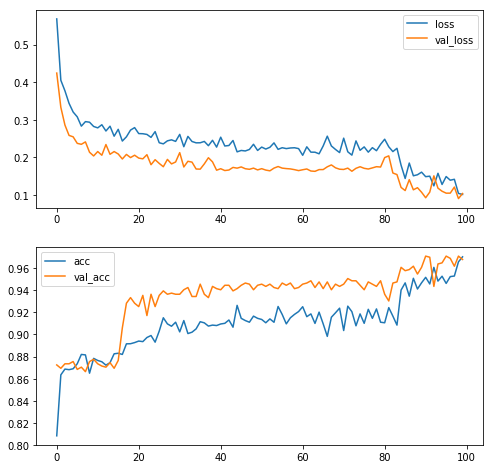

In [13]:
plot_training_histories(history, history_pt2, history_pt3);

In [14]:
detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-5),
                     metrics=['acc'])

history_pt4 = detector.fit_generator(train_generator,
                                     steps_per_epoch=20,
                                     epochs=30,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-unfrozen-10e-5.h5')

Epoch 1/30
20/20 [==============================] - 17s 868ms/step - loss: 0.1210 - acc: 0.9630 - val_loss: 0.0965 - val_acc: 0.9676
Epoch 2/30
20/20 [==============================] - 13s 648ms/step - loss: 0.0945 - acc: 0.9707 - val_loss: 0.0869 - val_acc: 0.9747
Epoch 3/30
20/20 [==============================] - 14s 699ms/step - loss: 0.0816 - acc: 0.9730 - val_loss: 0.0856 - val_acc: 0.9717
Epoch 4/30
20/20 [==============================] - 14s 685ms/step - loss: 0.0841 - acc: 0.9727 - val_loss: 0.0979 - val_acc: 0.9727
Epoch 5/30
20/20 [==============================] - 13s 671ms/step - loss: 0.0907 - acc: 0.9740 - val_loss: 0.0857 - val_acc: 0.9717
Epoch 6/30
20/20 [==============================] - 14s 676ms/step - loss: 0.1032 - acc: 0.9650 - val_loss: 0.0900 - val_acc: 0.9737
Epoch 7/30
20/20 [==============================] - 13s 650ms/step - loss: 0.0880 - acc: 0.9780 - val_loss: 0.0876 - val_acc: 0.9717
Epoch 8/30
20/20 [==============================] - 16s 789ms/step - 

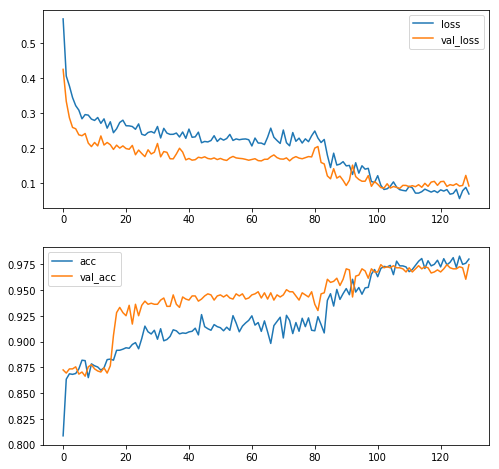

In [15]:
plot_training_histories(history, history_pt2, history_pt3, history_pt4);